# Blackbox internals #1


## Autowrappers

Autowrappers are an auxiliary to create black box module instances (like technology specific IP blocks)

1. `@autowrap` : A simple autowrapper taking the signals and converting them 1:1
+  `@autowrap_unroll(mapper)` : An autowrapper taking a custom unrolling mapper function.

    This kind of unrolling is required, when a module takes only single pin wires, i.e. instead of an address
    vector signal `A[0..9]` uses single pin (bool type) signals: `A0, A1, .. A9`.

In [1]:
import config

In [2]:
from synthesis.yosys.autowrap import autowrap_unroll
from myhdl import *
from myhdl._Signal import _Signal
from collections import OrderedDict

def translate(name, sig):
    l = len(sig)
    r = range(l)
    mapping = [ ("%s%d" % (name, i), 1) for i in r]
    return mapping

def bulk_unroll(args, argnames):
    "Simple bulk unrolling"
    mapping = {}
    for i, n in enumerate(argnames):
        sig = args[i]
        name = n[0]

        if isinstance(sig, _Signal):
            if sig._type == intbv:
                ns = translate(name, sig)
                mapping[name] = ns
            elif sig._type == bool:
                mapping[name] = [(name, 1)]
        elif isinstance(sig, bool):
            mapping[name] = [(name, 1)]
        else:
            raise ValueError("Unsupported type", type(sig))        
    return mapping        

def set_input(*args):
    for i in args:
        if isinstance(i, _Signal):
            i.read = True

@autowrap_unroll(bulk_unroll)
def UNROLL_ELEMENT(CLK, CE, RST, A, B, P, Q, VALID):

    #Note BUG: Slice signal not resolved, use
    # explicit indexing in assign() below
    # Also note: ConcatSignal does not preserve
    # ResetSignal properties.
    clk0, clk1 = [ Signal(bool()) for i in range(2) ]
    val0, val1 = [ Signal(bool()) for i in range(2) ]
    
    @always_comb
    def assign():
        clk0.next = CLK[0]
        clk1.next = CLK[1]
        VALID.next = concat(val0, val1)

    @always(clk0.posedge)
    def worker0():
        "Explicit synchronous reset"
        if RST[0]:
            P.next = 0
        elif CE[0]:
            P.next = A + B
        val0.next = CE[0] 

    @always(clk1.posedge)
    def worker1():
        if CE[1]:
            Q.next = A - B      
        val1.next = CE[1] 
        
    @instance
    def emulate():
        # FIXME: Analyze should recognize driver signals in @instance funcs as well

        yield delay(1)
        if __debug__:
            raise ValueError("Not supported")

    return worker0, worker1, assign, emulate

Note there's a small bug (something missing) in the wiring. Do you see it?

In [3]:
from myhdl import *

@block
def test(clk, ce, reset, a, b, p, q, valid):
    # Note: Shadow signals are always marked 'driven'
    CLK_DUP = ConcatSignal(*[clk for i in range(2)])
    CE_DUP = ConcatSignal(*[ce for i in range(2)])
    RST_DUP = ConcatSignal(*[reset for i in range(2)])  

    mul_better = UNROLL_ELEMENT(CLK_DUP, CE_DUP, RST_DUP, a, b, p, q, valid)

    return instances()

In [4]:
from myhdl.conversion import yshelper

mclk = Signal(bool())
en = Signal(bool())
valid = Signal(intbv()[2:])
reset = Signal(bool(0))
a, b = [ Signal(intbv()[5:]) for i in range(2) ]
p, q = [ Signal(intbv()[6:]) for i in range(2) ]

top = test(mclk, en, reset, a, b, p, q, valid)

design = yshelper.Design("mul")
top.convert("yosys_module", design)

design.finalize("top")

	Infer blackbox: 'UNROLL_ELEMENT_0_0'
Adding module with name: UNROLL_ELEMENT_2_2_2_5_5_6_6_2
ConcatSignal 'CE': 2 signals
ConcatSignal 'CLK': 2 signals
ConcatSignal 'RST': 2 signals
Custom mapping black box UNROLL_ELEMENT_0
Notice: A has no source
Notice: B has no source
Adding module with name: UNROLL_ELEMENT
Adding module with name: test_1_1_1_5_5_6_6_2
ConcatSignal 'CLK_DUP': 2 signals
ConcatSignal 'CE_DUP': 2 signals
ConcatSignal 'RST_DUP': 2 signals
Get Concat signal test_mclk
Get Concat signal test_mclk
Get Concat signal test_en
Get Concat signal test_en
Get Concat signal test_reset
Get Concat signal test_reset
++++++++ UNROLL_ELEMENT_0_0: UNROLL_ELEMENT_2_2_2_5_5_6_6_2 (Module) ++++++++


## RTL display

### Top level instance

Generating RTL image...
Display...


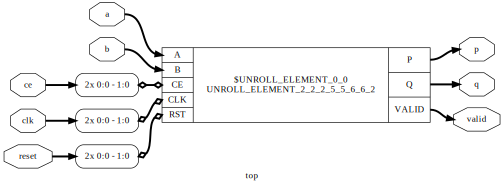

In [5]:
from ys_aux import to_svg
display(to_svg(design, "top", 75))

### Unrolled/wrapped blackbox element

Generating RTL image...
Display...


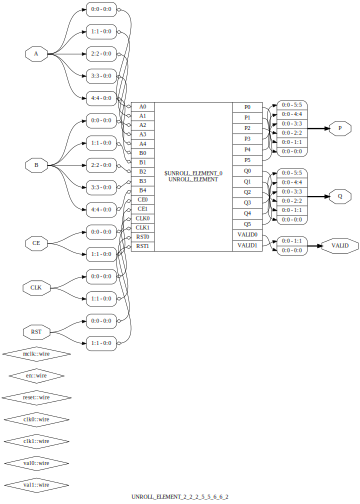

In [6]:
display(to_svg(design, "UNROLL_ELEMENT_2_2_2_5_5_6_6_2", 75))

You might want to validate the hierarchy:

In [7]:
design.test_synth()